In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import datetime
from importlib import reload  # Python 3.4+
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ExponentialLR

from libs.sequences import SeismicSequence
from libs.iris import irisRequests
from libs.distributions_ale import Weibull, InterTimeDistribution, Exponential, Gaussian_xy_mixture


# Data

In [29]:
#regions is a dictionary. regions['country'] contains minimum lat and max lat; minimum long and max long of that country

regions = {}
regions['greece'] = (30, 45,18, 44)
regions['california'] = (30, 41, -125, -113)
regions['japan'] = (20, 50, 120, 150)
regions['italy'] = (35, 46, 6, 19)

In [30]:
#load the japan data

load_cat = True
region_name = "japan"
region = regions[region_name]
if(load_cat):
    df = pd.read_csv("catalogs/" + region_name + ".csv", parse_dates=['Time']) #useful to tell to pd that the Time column is a date time column. Times are UTC
else:
    start_time = datetime.datetime(1980, 1, 1, 0, 0, 0)
    end_time =  datetime.datetime(2024, 1, 1, 0, 0, 0)
    download_url =irisRequests.url_events_box(start_time, end_time, region[0], region[1], region[2], region[3], minmag=3, magtype="MW")
    df = pd.read_csv(download_url, sep="|", comment="#")
    df.Time = pd.to_datetime(df.Time, errors='coerce')
    df.dropna(axis=0, inplace=True)
    df.sort_values(by="Time", inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.to_csv("catalogs/japan.csv", index=False)

/var/folders/h7/r96hnpz57nxft7rrtnbx7p7h0000gq/T/ipykernel_16086/1542237038.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("catalogs/" + region_name + ".csv", parse_dates=['Time']) #useful to tell to pd that the Time column is a date time column. Times are UTC


In [31]:
#divide our data into a test and train set
separation_time = datetime.datetime(2012, 1, 1, 0, 0, 0, tzinfo=datetime.UTC)
df_train = df[df.Time<separation_time]
df_test = df[df.Time>separation_time]

#get all the sequences first, and then divide into train and test sets according to prop
all_sequences = SeismicSequence.from_pandas_df(df, unit='s')
#proportion to split train and test sets
prop = df_train.shape[0]/(df_train.shape[0]+df_test.shape[0])

In [32]:
#get the train and test sets of times, lats, lons

use_random_length = False
duration_days = 3
duration = 60*60*24*duration_days # in seconds

with torch.no_grad():
    seqs = []
    t_start = duration
    max_t_end = all_sequences.t_end #sum of all inter_times between various events
    while(True):
        if(use_random_length):
            t_end = t_start + np.random.exponential()*duration
        else:
            t_end = t_start + duration
        if(t_end > max_t_end):
            break
        sub_seq = all_sequences.get_subsequence(t_start, t_end)
        if(len(sub_seq.arrival_times) > 0):
            seqs.append(sub_seq)  
        t_start = t_end
    inter_times, features, lengths = SeismicSequence.pack_sequences(seqs) 
    separate_times = int(inter_times.shape[0]*prop)

    #construct the train set
    #times
    inter_times_train = inter_times[0:separate_times]
    lengths_train = lengths[0:separate_times]
    #lats and lons (add a zero at the end to match the inter_times shape)
    features_lats_train = features[0:separate_times][:,:,0]
    features_lons_train = features[0:separate_times][:,:,1]
    new_shape = (features_lats_train.shape[0],  1)
    features_lats_train = torch.cat((features_lats_train, torch.zeros(new_shape)), dim=1)
    features_lons_train = torch.cat((features_lons_train, torch.zeros(new_shape)), dim=1)
    #scale lats and lons
    sc_lats = StandardScaler()
    sc_lons = StandardScaler()
    features_lats_train = torch.tensor(sc_lats.fit_transform(features_lats_train), dtype=torch.float32)
    features_lons_train = torch.tensor(sc_lons.fit_transform(features_lons_train), dtype=torch.float32)
    #magnitude (add a zero at the end to match the inter_times shape)
    magnitude_train = features[0:separate_times][:,:,2]
    new_shape = (magnitude_train.shape[0],  1)
    magnitude_train = torch.cat((magnitude_train, torch.zeros(new_shape)), dim=1)
    #merge into a unique train set
    input_time_features_train = inter_times_train.unsqueeze(-1)
    input_lats_features_train = features_lats_train.unsqueeze(-1)
    input_lons_features_train = features_lons_train.unsqueeze(-1)
    input_magnitude_train = magnitude_train.unsqueeze(-1)
    train_set = torch.cat((input_time_features_train, input_lats_features_train, input_lons_features_train, input_magnitude_train), dim=-1)


    #construct test set, as for the train
    #times
    inter_times_test = inter_times[separate_times::]
    lengths_test = lengths[separate_times::]
    #lats and lons
    features_lats_test = features[separate_times::][:,:,0]
    features_lons_test = features[separate_times::][:,:,1]
    new_shape = (features_lats_test.shape[0],  1)
    features_lats_test = torch.cat((features_lats_test, torch.zeros(new_shape)), dim=1)
    features_lons_test = torch.cat((features_lons_test, torch.zeros(new_shape)), dim=1)
    features_lats_test = torch.tensor(sc_lats.transform(features_lats_test), dtype=torch.float32)
    features_lons_test = torch.tensor(sc_lons.transform(features_lons_test), dtype=torch.float32)
    #magnitude
    magnitude_test = features[separate_times::][:,:,2]
    new_shape = (magnitude_test.shape[0],  1)
    magnitude_test = torch.cat((magnitude_test, torch.zeros(new_shape)), dim=1)


    #number of test events
    num_test = inter_times_test.shape[0]

# Model

In [33]:
#nll for the times
def get_time_nll_loss(inter_times : torch.Tensor, seq_lengths : torch.Tensor, inter_time_distr : InterTimeDistribution):
    log_prob = inter_time_distr.get_log_prob(inter_times)
    mask = SeismicSequence.pack_sequences_mask(seq_lengths, inter_times.shape[1])
    log_like = (log_prob * mask).sum(-1)  # (N,)
    log_surv = inter_time_distr.get_log_survival(inter_times)  # (N, L)
    end_idx = torch.unsqueeze(seq_lengths, -1)  # (N, 1)
    log_surv_last = torch.gather(log_surv, dim=-1, index=end_idx)  # (N, 1)
    log_like += log_surv_last.squeeze(-1)  # (N,)
    return -log_like

#nll for the (lat, lons) coordinates
def get_position_nll_loss(pos_lat : torch.Tensor, pos_lon : torch.Tensor,  seq_lengths : torch.Tensor, pos_distr : InterTimeDistribution):
    log_prob = pos_distr.get_log_prob(pos_lat, pos_lon)
    mask = SeismicSequence.pack_sequences_mask(seq_lengths, pos_lat.shape[1])
    log_like = (log_prob * mask).sum(-1)  # (N,)
    return -log_like

#nll for the magnitudes
def get_magnitude_nll_loss(magn : torch.Tensor, seq_lengths : torch.Tensor, magn_ditr : InterTimeDistribution):
    log_prob = magn_ditr.get_log_prob(magn)
    mask = SeismicSequence.pack_sequences_mask(seq_lengths, magn.shape[1])
    log_like = (log_prob * mask).sum(-1)  # (N,)
    return -log_like

In [34]:
class GRUPointProcess(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, n_mixtures):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.n_mixtures = n_mixtures
        
        self.weibull_mod = nn.Sequential(nn.Linear(hidden_dim, 2), nn.Softplus())

        #for the positions we need mean = (mean_x, mean_y); variances=(var_x, var_y)>0; cov=cov(x,y); for each gaussian, and Pi_params>0 with .sum()=1 
        self.gaussian_mod_mean = nn.Sequential(nn.Linear(hidden_dim, 2*self.n_mixtures))
        self.gaussian_mod_var = nn.Sequential(nn.Linear(hidden_dim, 2*self.n_mixtures), nn.Softplus())
        self.gaussian_mod_cov = nn.Sequential(nn.Linear(hidden_dim, 1*self.n_mixtures))
        self.Pi_params = nn.Sequential(nn.Linear(hidden_dim, 1*self.n_mixtures), nn.Softmax(dim=-1))

        #lambda for exponential distribution >0
        self.exp_mod_lambda = nn.Sequential(nn.Linear(hidden_dim, 1), nn.Softplus())
        

    def forward(self,x):
        rnn_output, _ = self.rnn(x)
        # shift forward along the time dimension and pad
        # so we can use it to model the inter times
        context = F.pad(rnn_output[:, :-1, :], (0,0, 1,0))

        weibull_params = self.weibull_mod(context)
        #we collect the parameters as (first n_mixture values are the lat_means), and (second n_mixture values are the lon_means)
        means_mix = self.gaussian_mod_mean(context)
        #same for the variances as for the means
        variances_mix = self.gaussian_mod_var(context)
        #each value of covariance is the covariance between lat and lon of a gaussian
        covariances_mix = self.gaussian_mod_cov(context)
        #probabilities of each gaussian
        Pi_params = self.Pi_params(context)

        lambda_coeff = self.exp_mod_lambda(context)

        distr_weib = Weibull(weibull_params[..., 0], weibull_params[..., 1])
        distr_gauss = Gaussian_xy_mixture(means_mix, variances_mix, covariances_mix, Pi_params, self.n_mixtures)
        distr_exp = Exponential(lambda_coeff[...,0])

        return context, distr_weib, distr_gauss, distr_exp

# Training

In [41]:
input_dim = train_set.shape[-1]
hidden_dim = 20
n_mixtures = 2
model = GRUPointProcess(input_dim, hidden_dim, n_mixtures)
optimizer = optim.AdamW(model.parameters(), lr=0.02)
epochs = 10
losses = [] 
losses_test = []
vals = []

In [ ]:
for epoch in range(epochs):
    print(epoch)
    optimizer.zero_grad()
    context, distr_weib, distr_gauss, distr_exp = model(train_set)
    #for easier manipulation in distribution.py, we repeat each data n_mixture times
    loss =  (get_position_nll_loss(features_lats_train.unsqueeze(-1).repeat(1,1,n_mixtures), features_lats_train.unsqueeze(-1).repeat(1,1,n_mixtures), lengths_train, distr_gauss).mean() 
    + get_time_nll_loss(inter_times_train, lengths_train, distr_weib).mean() 
    + get_magnitude_nll_loss(magnitude_train, lengths_train, distr_exp).mean())
    
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    with torch.no_grad():
        #collect the parameters for the test set
        #from each distrib., collect only the first row, as it equals the other
        b_base = distr_weib.b[0].detach()
        k_base = distr_weib.k[0].detach()
        means_mix = distr_gauss.mean_mix[0].detach() 
        variances_mix = distr_gauss.variances_mix[0].detach()
        covariances_mix = distr_gauss.covariances_mix[0].detach()
        Pi_params = distr_gauss.Pi_params[0].detach() 
        lambda_coeff = distr_exp.lambda_coeff[0].detach()

        #repeat the parameters a num_test number of times, to fit test set shapes
        distr_weib_test = Weibull(b_base.repeat(num_test,1), k_base.repeat(num_test,1))
        distr_gauss_test = Gaussian_xy_mixture(means_mix.repeat(num_test,1,1), variances_mix.repeat(num_test,1,1), covariances_mix.repeat(num_test,1,1), Pi_params.repeat(num_test,1,1), model.n_mixtures)
        distr_exp_test = Exponential(lambda_coeff.repeat(num_test,1))
        #get test loss as for train loss
        loss_test =  (get_position_nll_loss(features_lats_test.unsqueeze(-1).repeat(1,1,n_mixtures), features_lats_test.unsqueeze(-1).repeat(1,1,n_mixtures), lengths_test, distr_gauss_test).mean() 
        + get_time_nll_loss(inter_times_test, lengths_test, distr_weib_test).mean() 
        + get_magnitude_nll_loss(magnitude_test, lengths_test, distr_exp_test).mean())
        #collect train and test losses
        losses.append(loss.detach().numpy())
        losses_test.append(loss_test)

    print(f'train_loss = {loss.item()}')
    print(f'test_loss = {loss_test.item()}')

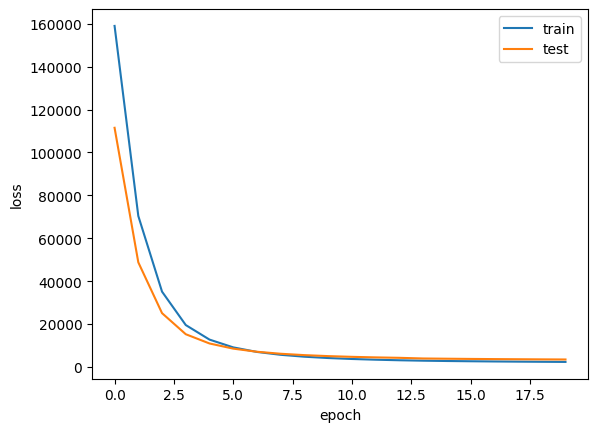

In [ ]:
#plot the train and test losses
plt.plot(losses, label='train')
plt.plot(losses_test, label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()